Preliminary analysis of the project data. One first imports all necessary packages

In [284]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load Data:
Data is loaded from the path and graph folder.

In [285]:
# Folder
PATH_FOLDER = 'wikispeedia_paths-and-graph/'

# Defining paths
ARTICLES_DATA = PATH_FOLDER + "articles.tsv"
CATEGORIES_DATA = PATH_FOLDER + "categories.tsv"
LINKS_DATA = PATH_FOLDER + "links.tsv"
PATH_FINISHED_DATA = PATH_FOLDER + "paths_finished.tsv"
PATH_UNFINISHED_DATA = PATH_FOLDER + "paths_unfinished.tsv"
SHORTESTPATH_DATA = PATH_FOLDER + "shortest-path-distance-matrix.txt"

# Loading all data series
articles = pd.read_csv(ARTICLES_DATA, header=None, names=['article'], comment='#', encoding='utf-8')
categories = pd.read_csv(CATEGORIES_DATA, sep='\t', header=None, names=['article', 'category'], comment='#', encoding='utf-8')
links = pd.read_csv(LINKS_DATA, sep='\t', header=None, names=["linkSource", 'linkTarget'], comment='#', encoding='utf-8')
path_finished = pd.read_csv(PATH_FINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], comment='#', encoding='utf-8')
path_unfinished = pd.read_csv(PATH_UNFINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], comment='#', encoding='utf-8')
shortest_path = pd.read_csv(SHORTESTPATH_DATA, sep='\t', header=None, names=['shortestPath'], comment='#', encoding='utf-8')


In [286]:
categories.head()

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [287]:
# For now we don't use it 
shortest_path.head()

,shortestPath
0,0_____33333325634333435_2433544334_3_422343544...
1,_0____22222325623232424_2422544324_3_312242544...
2,__0___33222425623232324_2333444433_3_422343434...
3,___0__33333325634233334_2433434333_2_423343433...
4,____0_22323335633332435_2433545434_3_423343544...


In [288]:
# Conversion of Unix to Christian time for the path files
path_finished['timestamp'] = pd.to_datetime(path_finished['timestamp'], unit='s', origin='unix')
path_unfinished['timestamp'] = pd.to_datetime(path_finished['timestamp'], unit='s', origin='unix')
path_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [289]:
# Adrticle names are URL-encoded. We can decode the article names for better readabilty using:
#from urllib.parse import unquote

#articles['article'].apply(lambda x : unquote(x))

# 2) Check the categories data:

One first checks if some Na values appear among categories.

In [290]:
categories.isna().sum()

article     0
category    0
dtype: int64

Overview on the dataset.

In [291]:
categories.describe()

,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


One then groups all articles by category.

In [292]:
categories_grouped = categories.groupby(by="category")
nb_categories = categories_grouped.ngroups
print("There are {} categories in the dataset.".format(nb_categories))

There are 129 categories in the dataset.


The histogram provides the distribution of articles per category.

Juste une question (Manon): ça représente quoi l'axe x? est ce que c'est les différentes catégories? est ce qu'il faudrait pas du coup mettre aussi les noms de ces catégories? Enfin je suis pas trop sure de comprendre ce qui est représenté

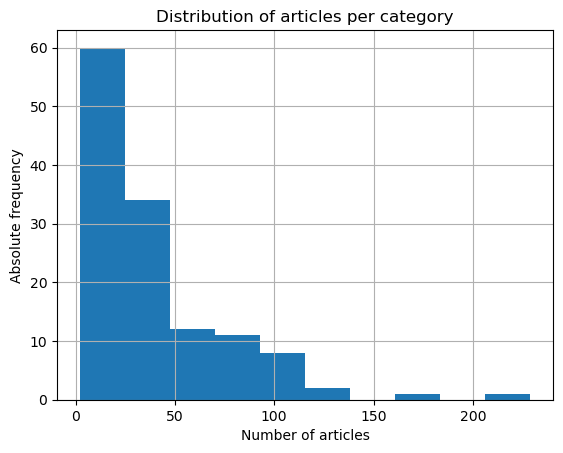

In [293]:
nb_articles_per_category = categories_grouped.size()
nb_articles_per_category.hist()
plt.xlabel('Number of articles')
plt.ylabel('Absolute frequency')
plt.title('Distribution of articles per category');

One then considers specific categories: countries, geographic regions and people. To get the number of articles belonging to each category, one checks if a given keyword belongs to the category string.

### Countries:

In [294]:
#countries = categories_grouped.filter(lambda x: 'Countries' in str(x['category']))
# (Flore) Version plus simple de le faire:
countries = categories_grouped.get_group('subject.Countries')
#print("There are {} countries in the dataset.".format(all_countries.size))
# (Flore) ATTENTION !! Ne pas utiliser .size mais len() pour avoir le nb de pays, etc, sinon donne pas la bonne chose
print("There are {} countries in the dataset.".format(len(countries)))

countries

There are 229 countries in the dataset.


,article,category
2,%C3%85land,subject.Countries
5,%C3%89ire,subject.Countries
102,Abkhazia,subject.Countries
109,Abu_Dhabi,subject.Countries
141,Afghanistan,subject.Countries
...,...,...
5022,West_Bank,subject.Countries
5031,Western_Sahara,subject.Countries
5159,Yemen,subject.Countries
5182,Zambia,subject.Countries


In [295]:
countries.describe()

,article,category
count,229,229
unique,229,1
top,%C3%85land,subject.Countries
freq,1,229


Group the countries by continent:

In [296]:
European_countries= categories_grouped.get_group('subject.Geography.European_Geography.European_Countries')
European_countries.insert(1, 'Continent', 'European')
print('There are {} European countries'.format(len(European_countries)))

Asian_countries= categories_grouped.get_group('subject.Geography.Geography_of_Asia.Asian_Countries')
Asian_countries.insert(1, 'Continent', 'Asian')
print('There are {} Asian countries'.format(len(Asian_countries)))


African_countries= categories_grouped.get_group('subject.Geography.African_Geography.African_Countries')
African_countries.insert(1, 'Continent', 'African')
print('There are {} African countries'.format(len(African_countries)))

SC_American_countries= categories_grouped.get_group('subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries')
SC_American_countries.insert(1, 'Continent', 'SC American')
print('There are {} Central/South American countries'.format(len(SC_American_countries)))

Mid_Eastern_countries= categories_grouped.get_group('subject.Geography.Geography_of_the_Middle_East.Middle_Eastern_Countries')
Mid_Eastern_countries.insert(1, 'Continent', 'Middle Eastern')
print('There are {} Middle Eastern countries'.format(len(Mid_Eastern_countries)))


There are 56 European countries
There are 37 Asian countries
There are 57 African countries
There are 48 Central/South American countries
There are 18 Middle Eastern countries


In [297]:
#Need to do it differently for North American countries, because there is no .North_American_Countries category :(
North_American_geography= categories_grouped.get_group('subject.Geography.North_American_Geography')
North_American_countries = pd.DataFrame(columns = ['article','category'])
for idx, NA_geo in enumerate(North_American_geography['article']):
    if (NA_geo in countries['article'].unique()):
        North_American_countries= pd.concat([North_American_countries, North_American_geography[North_American_geography.article==NA_geo]] ,join='outer')

North_American_countries.insert(1, 'Continent', 'North American')

In [298]:
#Same for Oceania/Australasia continent
Geography_of_Oceania_Australasia = categories_grouped.get_group('subject.Geography.Geography_of_Oceania_Australasia')
Oceania_Australasia_countries = pd.DataFrame(columns = ['article','category'])
for idx, Oce_geo in enumerate(Geography_of_Oceania_Australasia['article']):
    if (Oce_geo in countries['article'].unique()):
        Oceania_Australasia_countries= pd.concat([Oceania_Australasia_countries, Geography_of_Oceania_Australasia[Geography_of_Oceania_Australasia.article==Oce_geo]] ,join='outer')

Oceania_Australasia_countries.insert(1, 'Continent', 'Oceania Australasia')

Add the continent information to the countries. NaN of category_x correspond that are not directly classified as a country, only as a country that belongs to a continent. Ex: Mayotte is a region of France but is actually an island located in Africa!

In [299]:
all_continents = pd.concat([European_countries, Asian_countries, African_countries, SC_American_countries, Mid_Eastern_countries, North_American_countries, Oceania_Australasia_countries])
all_countries = countries.merge(all_continents, how='outer', on = ['article'])
all_countries.sample(10)

,article,category_x,Continent,category_y
76,French_Guiana,subject.Countries,SC American,subject.Geography.Central_and_South_American_G...
29,Botswana,subject.Countries,African,subject.Geography.African_Geography.African_Co...
129,Martinique,subject.Countries,SC American,subject.Geography.Central_and_South_American_G...
104,Italy,subject.Countries,European,subject.Geography.European_Geography.European_...
34,Bulgaria,subject.Countries,European,subject.Geography.European_Geography.European_...
62,East_Timor,subject.Countries,Asian,subject.Geography.Geography_of_Asia.Asian_Coun...
172,Saint_Kitts_and_Nevis,subject.Countries,SC American,subject.Geography.Central_and_South_American_G...
67,Equatorial_Guinea,subject.Countries,African,subject.Geography.African_Geography.African_Co...
147,Nigeria,subject.Countries,African,subject.Geography.African_Geography.African_Co...
145,Nicaragua,subject.Countries,SC American,subject.Geography.Central_and_South_American_G...


Repartition of the number of countries per continent.

<AxesSubplot:>

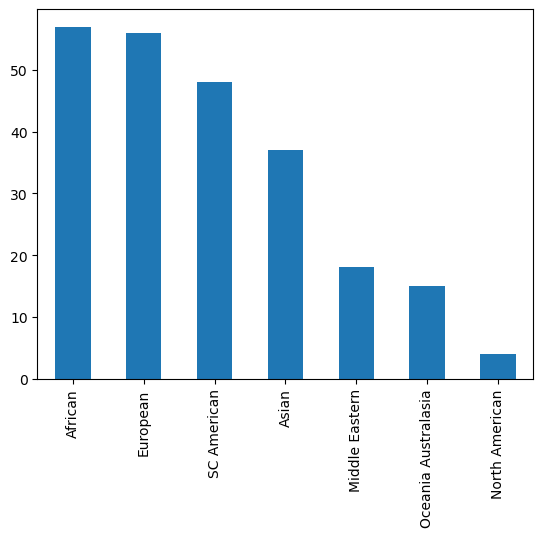

In [300]:
all_countries['Continent'].value_counts().plot(kind="bar")

# People

One first determines how many classes of people there are, before creating groups.

In [301]:
people = categories_grouped.filter(lambda x: 'People' in str(x['category'])) 
people_grouped = people.groupby(by="category")
nb_people_categories = people_grouped.ngroups
print("There are {0} people in the dataset, that are divided in {1} different classes.".format(len(people),nb_people_categories))

# ATTENTION: Pour le nombre de personnes c'est pas tout à fait juste car certaines personnes apparaissent dans plusieurs catégories
# Le code en dessous donne vraiment le nombre de personne 

There are 711 people in the dataset, that are divided in 21 different classes.


In [302]:
#Count number of distinct elements in specified axis.
people.nunique()
print("There are {0} people in the dataset, that are divided in {1} different classes.".format(people.nunique()[0],people.nunique()[1]))


There are 698 people in the dataset, that are divided in 21 different classes.


In [303]:
people

,article,category
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
4,%C3%89douard_Manet,subject.People.Artists
8,%C3%93engus_I_of_the_Picts,subject.People.Historical_figures
67,A._E._J._Collins,subject.People.Sports_and_games_people
88,Abbas_I_of_Persia,subject.People.Historical_figures
...,...,...
5188,Zhang_Qian,subject.People.Historical_figures
5190,Zheng_He,subject.People.Historical_figures
5191,Ziad_Jarrah,subject.People.Historical_figures
5197,Zionism,subject.People.Political_People


Let's have an overview of the 21 categories.

<AxesSubplot:>

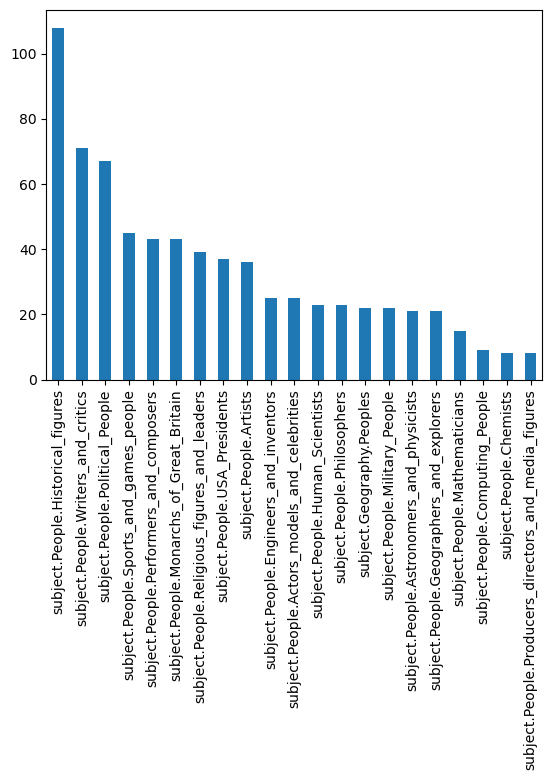

In [304]:
people['category'].value_counts().plot(kind="bar")

One gathers those classes in bigger categories. But which criterion to choose?

In [305]:
historical_figures = categories_grouped.get_group('subject.People.Historical_figures')

### Try to extract usefull information from plaintext


1) Test avec Albert Einstein:


In [323]:
import re

PATH_FOLDER = 'plaintext_articles/'

# Defining paths
Article_Albert_Einstein = open(PATH_FOLDER +"Albert_Einstein.txt",'r')
lines_AE = Article_Albert_Einstein.readlines()

In [307]:
# A list to append extracted data
list_extracted_data = []
for line in lines_AE:
# Flag is True if the line starts (special character for start: \A) with 'Id of the track'
    flag = re.search('Born',line)
    if flag:
        start_index = re.search('Born',line).end()
        end_index = re.search('\n',line).start() 
# Select the indices from each line as it contains our extracted data
        list_extracted_data.append(line[start_index:end_index])
        break
print(list_extracted_data)

['      March 14, 1879']


2. Try to make it as functions:


In [319]:
def read_plain_text(article_name):
    print(article_name)
    article = open(PATH_FOLDER + article_name +".txt",'r')
    lines_text = article.readlines()
    return lines_text

In [312]:
def extract_data_from_plain_text(article_name, list_extracted_data, word):

    print(article_name)
    lines_text = read_plain_text(str(article_name))
    for line in lines_text:
    # Flag is True if the line starts (special character for start: \A) with 'Id of the track'
        flag = re.search(word,line)
        if flag:
            start_index = re.search(word,line).end()
            end_index = re.search('\n',line).start() 
    # Select the indices from each line as it contains our extracted data
            list_extracted_data.append(line[start_index:end_index])
            print('Found word')
            break
    # If the word is not present at all (ex:didn't die) add Nan
    if not flag:
        list_extracted_data.append(['NaN'])
        print('Not found')
    print(list_extracted_data)
    return list_extracted_data

Try extracting the birth dates of the people:

Je crois que ça fonctionne pas à cause des charatères spéciaux lol

In [320]:
birth_dates=[]
test=people['article'].apply(lambda x: read_plain_text(x))



%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
done


UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 18: character maps to <undefined>

In [241]:
# Utiliser une fois qu'on aura extrès les dates
#df['col'] = pd.to_datetime(df['col'])

# Linking people and countries

To see how countries and people are related, one looks at the links file and keeps only relationships showing how people are linked to countries and the converse.

In [291]:
links.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [292]:
links.describe()

,linkSource,linkTarget
count,119882,119882
unique,4587,4135
top,United_States,United_States
freq,294,1551


The description already shows that the most common link source and target is the United States. This is non-trivial, since the metric is non-symmetric.

In [293]:
links.isna().sum()

linkSource    0
linkTarget    0
dtype: int64

No Na value appears in the file, so one can directly begin to play with data.

One can now distinguish four different subsets that relate countries and people: 1) How a given source country reaches target people. 2) How a given target people is reached by source countries. 3) How a given source person reaches target countries. 4) How a given target country is reached by source people.
Studying these four subsets should provide insights on the asymmetry degree of the relationships and the way people and countries are related.

First, one divides the links dataset in two groups: one according to the source, the other to the target.

In [294]:
grouped_source_links = links.groupby(by="linkSource")
grouped_source_links.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119867,Zulu,AK-47
119868,Zulu,Bantu
119869,Zulu,Cape_Town
119870,Zulu,Christianity


In [295]:
grouped_source_links.describe()

linkTarget                            
                                      count unique             top freq
linkSource                                                             
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in         11     11            Bede    1
%C3%85land                               19     19    20th_century    1
%C3%89douard_Manet                       20     20        Absinthe    1
%C3%89ire                                 8      8          Canada    1
%C3%93engus_I_of_the_Picts               10     10  D%C3%A1l_Riata    1
...                                     ...    ...             ...  ...
Zionism                                  74     74    18th_century    1
Zirconium                                42     42       Aluminium    1
Zoroaster                                28     28    18th_century    1
Zuid-Gelders                              5      5      Brabantian    1
Zulu                                     15     15           AK-47    1

[4587 rows x 4 columns]

In [296]:
grouped_target_links = links.groupby(by="linkTarget")
grouped_target_links.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119862,Zuid-Gelders,Brabantian
119864,Zuid-Gelders,East_Flemish
119872,Zulu,History_of_South_Africa
119873,Zulu,Ladysmith_Black_Mambazo


In [297]:
grouped_target_links.describe()

linkSource                                 
                  count unique                  top freq
linkTarget                                              
10th_century         65     65         11th_century    1
11th_century         57     57         10th_century    1
12th_century         85     85         11th_century    1
13th_century         84     84         11th_century    1
14th_century         71     71         11th_century    1
...                 ...    ...                  ...  ...
Zionism              25     25         19th_century    1
Zirconium            15     15              Calcium    1
Zoroaster             9      9  Friedrich_Nietzsche    1
Zuid-Gelders          5      5           Brabantian    1
Zulu                 14     14         19th_century    1

[4135 rows x 4 columns]

Filtering is made using the check_word function. It checks if the article belongs to the countries or people list.

In [186]:
import re

def check_word(word, list_words):
    '''Inputs:
            word: string
            list_words: string
        Return:
            True if the word is in the list_words
            False otherwise
    '''
    if any(article in re.findall(r"[\w']+", word) for article in list_words):
        return True 
    else:
         return False

One calls the four subsets as following: 1) country_to_people 2) people_from_country 3) people_to_country 4) country_from_people. One proceeds in two steps: first isolate the country or people of interest on one column, then on the other.

Comment Killian: ça prend un temps fou à s'exécuter, dites si vous avez une méthode plus rapide.

In [303]:
country_to_people = grouped_source_links.filter(lambda x : check_word(str(x['linkSource']), str(all_countries['article'])) & check_word(str(x['linkTarget']), str(people_grouped['article'])))
print('There are {} countries that target people.'.format(len(country_to_people)))
people_from_country = grouped_source_links.filter(lambda x :check_word(str(x['linkSource']), str(people_grouped['article'])) & check_word(str(x['linkTarget']), str(all_countries['article'])))
print('There are {} people that are targeted by countries.'.format(len(people_from_country)))
people_to_country = grouped_target_links.filter(lambda x : check_word(str(x['linkSource']), str(all_countries['article'])) & check_word(str(x['linkTarget']), str(people_grouped['article'])))
print('There are {} people that target countries.'.format(len(people_to_country)))
country_from_people = grouped_source_links.filter(lambda x : check_word(str(x['linkSource']), str(people_grouped['article'])) & check_word(str(x['linkTarget']), str(all_countries['article'])))
print('There are {} countries that are targeted by people.'.format(len(country_from_people)))

There are 127 countries that target people.
There are 141 people that are targeted by countries.
There are 1061 people that target countries.
There are 145 countries that are targeted by people.


# Links between articles

One first considers countries for the finished paths. What are their occurences?

In [ ]:
path_finished.head()

In [ ]:
path_finished.describe()

Looking at the paths, one counts the number of occurencies of countries in them, with the function check_words_in_list.

## Graph Analysis 

(Manon): J'ai lu un article très intéressant avec beaucoup de choses que l'on pourrait reprendre, je pensais commencer par essayer de regarder un peu comme ils font
https://studentwork.prattsi.org/infovis/labs/exploring-the-network-behind-wikispeedia/ \\

The idea is to focus on the graph of finished paths (at first) and then filter the paths where '<' occurs (i.e. the paths where the player had pressed the back button), but in a second step we could also decide to keep these paths but just delete the '<' as well as the previous page.

In [ ]:
def check_character(headline, character):
    '''Inputs:
            headline: string
            list_words: string
        Return:
            1 if the character is in the headline
            0 otherwise
    '''
    if character in headline: #
        return 1 
    else:
         return 0

In [ ]:
path_finished['back'] = path_finished['path'].apply(lambda x : check_character(x, '<'))
path_finished_filtered = path_finished[path_finished['back']==0]

Then we need to create a graph. To this end, we will use `nx.add_path`. However, this function needs a list of successive nodes(i.e. the successsive articles). Thus we first need to transform the paths.

In [ ]:
def Convert(string):
    li = list(string.split(";"))
    return li

In [ ]:
path_finished_filtered['path'] = path_finished_filtered['path'].apply(lambda x : Convert(x))


In [ ]:
path_finished_filtered['path'][2]

Eventually we create the graph: (To check (Manon): Je suis pas sure que an le créant comme je l'ai fait le poids des liaisons entre les noeuds et proportionnel au nombre de fois où j'ai mis la liaison)

In [ ]:
import networkx as nx

G = nx.Graph()
for index, row in path_finished_filtered.iterrows(): 
    nx.add_path(G, row['path'])
    

In [ ]:
list(G.nodes)

In [ ]:
nx.info(G)

In [ ]:
nx.degree_histogram(G)

**Degree centrality :** This is based on the assumption that important nodes have many connections \
$d(v) = \frac{d_v}{|N|-1}$ where $d_v$  is the degree of node $v$ and $N$ is the set of all nodes.

In [ ]:
deg_centrality = nx.degree_centrality(G)
deg_centrality_df = pd.DataFrame.from_dict(deg_centrality, orient='index')
deg_centrality_df.idxmax() # As expected, the United_States 

**Pagerank**

In [ ]:
pr = nx.pagerank(G, alpha = 0.8)
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.idxmax()

Il y a plein de mesures différentes pour mesurer l'importance des nodes, cf ce lien : https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/. Je n'en ai implémenté que deux pour le moment mais il faut choisir celui/celles qui sont le plus pertinent (Manon)

Ensuite on peut mesurer la centralité et tout ce dont j'avais parlé directement avec le package `nx`, j'ai compris comment faire je crois, je continue dans la semaine.